In [18]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
import timm
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import timm
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
from torchvision.models import convnext_base
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score

# Config
MODEL_PATH = 'best_efficientnet_b4.pth'  # 학습된 모델 경로
TEST_IMG_PATH = 'test'
OUTPUT_CSV_PATH = 'submission_single_efficientnetb44_tta.csv'
IMG_SIZE = 448  # 학습 시 사용한 이미지 크기
NUM_CLASSES = 17

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"🖥️ Device: {DEVICE}")
print("✅ Import 완료!")


🖥️ Device: cuda
✅ Import 완료!


In [19]:
# ============================
# Cell 2: 모델 정의
# ============================
class EfficientNetB4Classifier(nn.Module):
    def __init__(self, num_classes=17):
        super().__init__()
        # ✅ timm으로 모델 생성
        self.model = timm.create_model('efficientnet_b4', pretrained=False, num_classes=num_classes)
    
    def forward(self, x):
        return self.model(x)

print("✅ 모델 클래스 정의 완료!")

# ============================
# 2. 모델 인스턴스 생성 (✅ 이게 빠졌음!)
# ============================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNetB4Classifier(num_classes=17).to(DEVICE)
print(f"✅ 모델 인스턴스 생성 완료! (Device: {DEVICE})")

# ============================
# 3. 가중치 로드 (✅ 이것도 필요!)
# ============================
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE), strict=False)
model.eval()
print(f"✅ 모델 가중치 로드 완료: {MODEL_PATH}")

✅ 모델 클래스 정의 완료!
✅ 모델 인스턴스 생성 완료! (Device: cuda)
✅ 모델 가중치 로드 완료: best_efficientnet_b4.pth


In [20]:
def get_tta_transforms(img_size):
    """
    5가지 TTA 변환 생성
    1. 원본
    2. 수평 뒤집기
    3. 수직 뒤집기
    4. 수평+수직 뒤집기
    5. 회전 (5도)
    """
    tta_list = [
        # 원본
        A.Compose([
            A.Resize(height=img_size, width=img_size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ]),
        # 수평 뒤집기
        A.Compose([
            A.Resize(height=img_size, width=img_size),
            A.HorizontalFlip(p=1.0),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ]),
        # 수직 뒤집기
        A.Compose([
            A.Resize(height=img_size, width=img_size),
            A.VerticalFlip(p=1.0),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ]),
        # 수평+수직 뒤집기
        A.Compose([
            A.Resize(height=img_size, width=img_size),
            A.HorizontalFlip(p=1.0),
            A.VerticalFlip(p=1.0),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ]),
        # 회전
        A.Compose([
            A.Resize(height=img_size, width=img_size),
            A.Rotate(limit=5, p=1.0),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ]),
    ]
    return tta_list

tta_transforms = get_tta_transforms(IMG_SIZE)
print(f"✅ TTA 변환 {len(tta_transforms)}개 생성 완료!")


✅ TTA 변환 5개 생성 완료!


In [21]:
class TTADataset(torch.utils.data.Dataset):
    def __init__(self, img_path, img_size, tta_transforms):
        self.img_path = img_path
        self.img_size = img_size
        self.tta_transforms = tta_transforms
        
        # 이미지 파일 리스트 가져오기 (jpg, png, jpeg 등)
        self.img_files = sorted(glob(os.path.join(img_path, '*.*')))
        # 확장자 필터링 (이미지 파일만)
        self.img_files = [f for f in self.img_files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        print(f"✅ Test 이미지 {len(self.img_files)}개 발견")
        
    def __len__(self):
        return len(self.img_files) * len(self.tta_transforms)
    
    def __getitem__(self, idx):
        # 원본 이미지 인덱스와 TTA 인덱스 계산
        img_idx = idx // len(self.tta_transforms)
        tta_idx = idx % len(self.tta_transforms)
        
        img_path = self.img_files[img_idx]
        img = cv2.imread(img_path)
        
        if img is None:
            raise ValueError(f"이미지를 로드할 수 없습니다: {img_path}")
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # TTA 적용
        transform = self.tta_transforms[tta_idx]
        img = transform(image=img)['image']
        
        return img, img_idx

print("✅ TTA Dataset 클래스 정의 완료!")


✅ TTA Dataset 클래스 정의 완료!


In [22]:
# Dataset 생성
test_dataset = TTADataset(
    img_path=TEST_IMG_PATH,
    img_size=IMG_SIZE,
    tta_transforms=tta_transforms
)

# DataLoader 생성
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=16, shuffle=False, num_workers=4
)

num_images = len(test_dataset.img_files)
print(f"✅ Test 이미지: {num_images}개")
print(f"✅ TTA 적용 후 총 샘플: {len(test_dataset)}개")
print(f"✅ 배치 수: {len(test_loader)}개")


✅ Test 이미지 3140개 발견
✅ Test 이미지: 3140개
✅ TTA 적용 후 총 샘플: 15700개
✅ 배치 수: 982개


In [23]:
# # 추론

num_tta = len(tta_transforms)
all_probs = np.zeros((num_images, NUM_CLASSES))

with torch.no_grad():
    for images, img_indices in tqdm(test_loader, desc="TTA 추론"):
        images = images.to(DEVICE)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        
        # 각 이미지 인덱스에 확률 누적
        for prob, img_idx in zip(probs, img_indices):
            all_probs[img_idx] += prob

# TTA 평균
all_probs /= num_tta
predictions = np.argmax(all_probs, axis=1)

print("✅ 추론 완료!")
print(f"📊 예측 분포:\n{pd.Series(predictions).value_counts().sort_index()}")


TTA 추론: 100%|██████████| 982/982 [01:04<00:00, 15.30it/s]

✅ 추론 완료!
📊 예측 분포:
0      132
1       23
2     1616
3        2
4      407
6      328
7       32
9        6
10      16
11       4
12      89
15       2
16     483
Name: count, dtype: int64


In [24]:
# 제출 파일 생성
img_files = test_dataset.img_files
img_ids = [os.path.basename(f) for f in img_files]  # 파일명만 추출

submission_df = pd.DataFrame({
    'ID': img_ids,
    'target': predictions
})

submission_df.to_csv(OUTPUT_CSV_PATH, index=False)

print(f"🎯 제출 파일 저장 완료: {OUTPUT_CSV_PATH}")
print("\n📋 최종 결과 미리보기:")
print(submission_df.head(10))
print(f"\n📊 예측 분포:\n{pd.Series(predictions).value_counts().sort_index()}")



🎯 제출 파일 저장 완료: submission_single_efficientnetb44_tta.csv

📋 최종 결과 미리보기:
                     ID  target
0  0008fdb22ddce0ce.jpg       0
1  00091bffdffd83de.jpg       2
2  00396fbc1f6cc21d.jpg      16
3  00471f8038d9c4b6.jpg       2
4  00901f504008d884.jpg       0
5  009b22decbc7220c.jpg       2
6  00b33e0ee6d59427.jpg       4
7  00bbdcfbbdb3e131.jpg      16
8  00c03047e0fbef40.jpg       2
9  00c0dabb63ca7a16.jpg       2

📊 예측 분포:
0      132
1       23
2     1616
3        2
4      407
6      328
7       32
9        6
10      16
11       4
12      89
15       2
16     483
Name: count, dtype: int64


✅ 나눔폰트 설정 완료!
📊 CSV 1: submission_single_efficientb4_tta_cp.csv
   - 총 예측 수: 3140
   - 예측 분포:
target
0     201
1      90
2     199
3     190
4     192
5     200
6     202
7     204
8     200
9     200
10    204
11    194
12    200
13    151
14    113
15    200
16    200
Name: count, dtype: int64

📊 CSV 2: submission_single_efficientnetb44_tta.csv
   - 총 예측 수: 3140
   - 예측 분포:
target
0      132
1       23
2     1616
3        2
4      407
6      328
7       32
9        6
10      16
11       4
12      89
15       2
16     483
Name: count, dtype: int64

📊 예측 분포 비교:
        CSV1_Count  CSV2_Count  Difference
target                                    
0              201         132         -69
1               90          23         -67
2              199        1616        1417
3              190           2        -188
4              192         407         215
5              200           0        -200
6              202         328         126
7              204          32        -172
8 

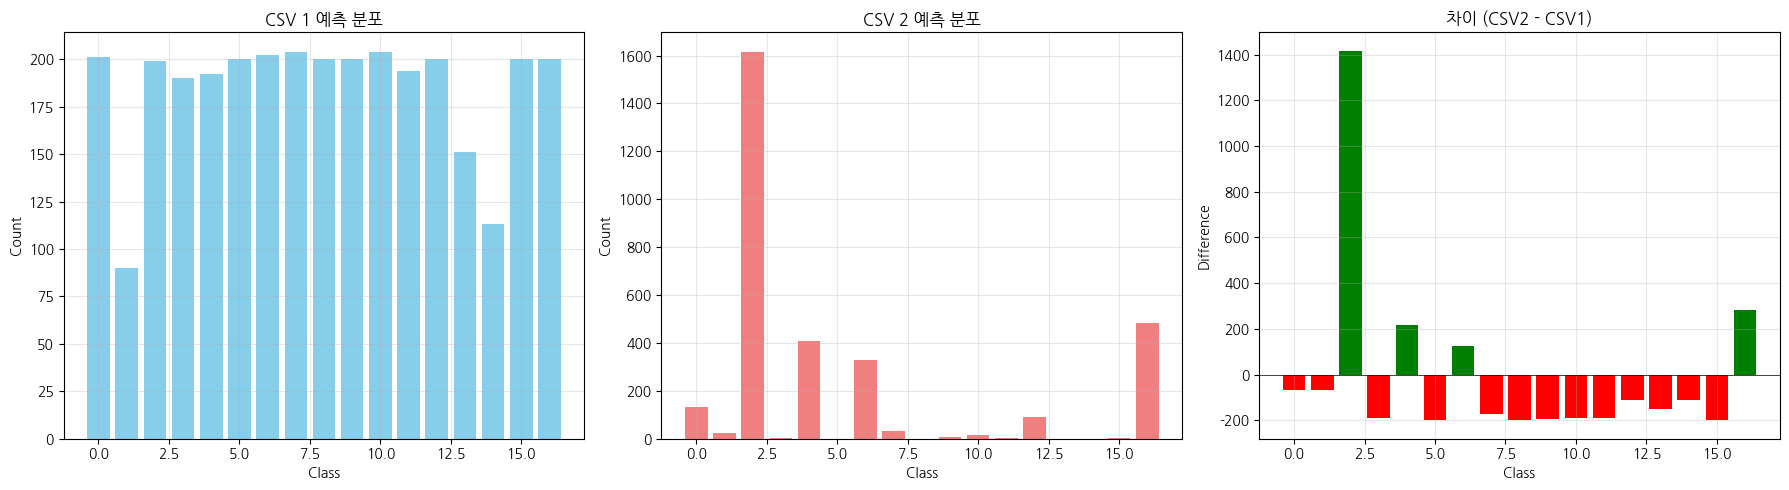


🔍 예측이 다른 샘플: 2980개 / 3140개
   일치율: 5.10%

예측이 다른 샘플 예시 (처음 10개):
                     ID  target_csv1  target_csv2
0  0008fdb22ddce0ce.jpg            2            0
1  00091bffdffd83de.jpg           12            2
2  00396fbc1f6cc21d.jpg            5           16
3  00471f8038d9c4b6.jpg           12            2
4  00901f504008d884.jpg            2            0
5  009b22decbc7220c.jpg           15            2
6  00b33e0ee6d59427.jpg            0            4
7  00bbdcfbbdb3e131.jpg            8           16
8  00c03047e0fbef40.jpg           15            2
9  00c0dabb63ca7a16.jpg           11            2


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
# ============================
# 나눔폰트 설정
# ============================
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 폰트 확인
try:
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    if 'NanumGothic' in available_fonts:
        print("✅ 나눔폰트 설정 완료!")
    else:
        print("⚠️ 나눔폰트 미설치!")
        print("   터미널 실행: sudo apt-get install fonts-nanum")
        print("   설치 후 커널 재시작 필요")
except Exception as e:
    print(f"❌ 폰트 설정 오류: {e}")
    
# 두 CSV 파일 경로
csv1_path = 'submission_single_efficientb4_tta_cp.csv'  # 첫 번째 제출 파일
csv2_path = 'submission_single_efficientnetb44_tta.csv'  # 두 번째 제출 파일

# CSV 파일 읽기
df1 = pd.read_csv(csv1_path)
df2 = pd.read_csv(csv2_path)

print(f"📊 CSV 1: {csv1_path}")
print(f"   - 총 예측 수: {len(df1)}")
print(f"   - 예측 분포:")
print(df1['target'].value_counts().sort_index())

print(f"\n📊 CSV 2: {csv2_path}")
print(f"   - 총 예측 수: {len(df2)}")
print(f"   - 예측 분포:")
print(df2['target'].value_counts().sort_index())

# 분포 비교 데이터프레임 생성
comparison_df = pd.DataFrame({
    'CSV1_Count': df1['target'].value_counts().sort_index(),
    'CSV2_Count': df2['target'].value_counts().sort_index()
}).fillna(0).astype(int)

comparison_df['Difference'] = comparison_df['CSV2_Count'] - comparison_df['CSV1_Count']

print("\n📊 예측 분포 비교:")
print(comparison_df)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# CSV 1 분포
axes[0].bar(comparison_df.index, comparison_df['CSV1_Count'], color='skyblue')
axes[0].set_title('CSV 1 예측 분포')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3)

# CSV 2 분포
axes[1].bar(comparison_df.index, comparison_df['CSV2_Count'], color='lightcoral')
axes[1].set_title('CSV 2 예측 분포')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].grid(True, alpha=0.3)

# 차이
axes[2].bar(comparison_df.index, comparison_df['Difference'], 
            color=['red' if x < 0 else 'green' for x in comparison_df['Difference']])
axes[2].set_title('차이 (CSV2 - CSV1)')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Difference')
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 예측이 다른 샘플 확인
if 'ID' in df1.columns and 'ID' in df2.columns:
    merged = pd.merge(df1, df2, on='ID', suffixes=('_csv1', '_csv2'))
    different_predictions = merged[merged['target_csv1'] != merged['target_csv2']]
    
    print(f"\n🔍 예측이 다른 샘플: {len(different_predictions)}개 / {len(df1)}개")
    print(f"   일치율: {(len(df1) - len(different_predictions)) / len(df1) * 100:.2f}%")
    
    if len(different_predictions) > 0:
        print("\n예측이 다른 샘플 예시 (처음 10개):")
        print(different_predictions[['ID', 'target_csv1', 'target_csv2']].head(10))
